<h1>Newton-Raphson<h1> 
<p>A method for a system of n nonlinear equations with n unknowns.</p>

In [1]:
import torch as th
import matplotlib.pyplot as plt

In [6]:
class NewtonRaphson:

  def __init__(self, x, tol, functions):
    self.x = x
    self.tolerance = tol
    self.functions = functions

  # Calculate the jacobian matrix
  def jacobianMatrix(self):
    jacobian = []
    for i in range(len(self.functions)):
      jacobian.append(list(map(lambda x: x.item(), list(th.autograd.functional.jacobian(self.functions[i], self.x)))))
    return th.tensor(jacobian)
  
  # Calculate inverse jacobian
  def inverseJacobian(self):
    return th.inverse(self.jacobianMatrix())

  # Calculate the function by replacing the unknowns variables with their values
  def functionCalculation(self):
    functionValues = []
    for function in self.functions:
      functionValues.append(function(self.x))
    return th.tensor([functionValues])

  # Check if the local error is greater than the tolerance
  def islocalErrorGreaterThanTolerance(self, counter, localErrors):
    errorsGreaterThanTolerance = 0
    for i in range(len(self.x)):
      if localErrors[counter][i] >= self.tolerance:
        errorsGreaterThanTolerance += 1
    
    return True if errorsGreaterThanTolerance == len(self.x) else False


  # Main Newton-Raphson algorithm
  def newtonRaphson(self):
    X = []
    localErrors = [[self.x[i].item() for i in range(len(self.x))]]
    counter = 0
    while counter < 10 and self.islocalErrorGreaterThanTolerance(counter, localErrors):

      # Calculate the jacobian and find anew solution given previous solution
      X.append(th.sub(self.x, th.transpose(th.mm(self.inverseJacobian(), th.transpose(self.functionCalculation(), 0, 1)), 0, 1)))

      # Calculate the local error for all the variables 
      localErrors.append([])
      for i in range(len(self.x)):
        localErrors[counter+1].append(abs(self.x[i].item() - X[counter][0][i].item()))
      

      # Update the solution x
      self.x = th.tensor(list(map(lambda x: x.item(), list(X[counter][0]))))

      # Update the counter
      counter += 1

    return X, localErrors

  # Graph the error for one variable
  def graphError(self, errors):
    error = [x[0] for x in errors]
    fig = plt.figure(1)
    plt.title("Error")
    plt.plot(error)
    plt.grid()	
    plt.show()



tensor([1.9900, 1.0100])
tensor([1.9950, 1.0050])
tensor([1.9975, 1.0025])
tensor([1.9988, 1.0012])
tensor([1.9994, 1.0006])
tensor([1.9998, 1.0002])
tensor([1.9998, 1.0002])
[1.9800000190734863, 1.0199999809265137]
[0.010001659393310547, 0.010001659393310547]
[0.00499570369720459, 0.00499570369720459]
[0.0024782419204711914, 0.0024782419204711914]
[0.0012750625610351562, 0.0012750625610351562]
[0.0006679296493530273, 0.0006679296493530273]
[0.0004100799560546875, 0.0004100799560546875]
[0.0, 0.0]


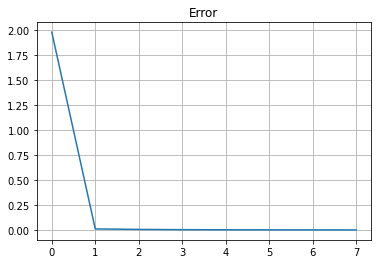

In [7]:
# Initial X
initialX = th.tensor([1.98, 1.02])

functions = []
functions.append(lambda x: x[0]+x[0]*x[1]-4)
functions.append(lambda x: x[0]+x[1]-3)
tolerance = 0.0003

NR = NewtonRaphson(initialX, tolerance, functions)
x, errors = NR.newtonRaphson()

# Show X results
for iteration in x:
  print(iteration[0])

# Show variable error results
for iteration in errors:
  print(iteration)

# Graph the error for one variable
NR.graphError(errors)
